![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

## The Unit Commitment Problem (UCP)

The Unit Commitment Problem is an optimization problem in electrical power production. The goal is to assign production levels and switch-on/switch-off times to generators in a network so that the total production at any time meets the predicted demand for electricity. In this demonstration we consider minimizing production cost subject to constraints on the generating units: minimal/maximal production levels, minimum uptime/downtime and maximum ramp-up/ramp-down. The cost consists of quadratic production costs, fixed operating cost and start-up costs. That makes our version of UCP a Mixed Integer Conic Quadratic Optimization problem (MICQO).

These are the most basic constraint types for a UCP model, see for example [this paper](http://pierrepinson.com/docs/HeideJorgensenetal2016.pdf) and references therein. We only model the total power generation of thermal units with constant startup costs, but not the storage capacity of hydro units nor cascades, power flow or bidding aspects; see for instance [a more thorough real-world model](https://www.ferc.gov/legal/staff-reports/rto-COMMITMENT-TEST.pdf). Many of those features could be added by extending our linear model. We use examples derived from datasets from the [OR-library](http://people.brunel.ac.uk/~mastjjb/jeb/info.html) (data is modified to fit into our framework). They are loaded with the script:

In [1]:
import ucpParser

The source file and examples are available in the GitHub repository containing this notebook. 

We demonstrate such aspects of working with MOSEK as:
* setting up a model,
* using variable slices to effectively write constraints,
* retrieving optimizer statistics,
* reoptimization.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
from mosek.fusion import *

## Problem formulation

In the UCP problem we are given a number $N$ of generators (*units*), a time horizon of $T$ *periods* (usually hours or half-hours) and initial conditions (see later). The goal is to determine electricity production levels for all units and all periods so that a total predicted *demand* is satisfied in each period. The operation of the units is subject to technical constraints which will be introduced below. The operating costs are known for each unit and can be split into *production costs*, *fixed operating costs* when the unit is on and *startup costs* incurred when the unit is switched on.

We can model this setup using these simple variables:

* a continous variable $p\in\mathbb{R}_+^{N\times T}$ such that $p_{i,t}$ is the power generation of unit $i$ at time $t$,
* a binary variable $u\in\{0,1\}^{N\times T}$, where $u_{i,t}$ indicates if unit $i$ is *on* (producing energy) at time $t$,
* a binary variable $v\in\{0,1\}^{N\times T}$, where $v_{i,t}$ indicates if unit $i$ has been started (switched from *off* to *on*) at time $t$, in other words $v_{i,t}=\max(u_{i,t}-u_{i-1,t},\ 0)$.

It will be convenient to declare variables of size $N\times(T+1)$ and use the first column for initial conditions, that is production levels and on/off status at the beginning of the simulation. The code that initializes a Fusion model is shown below.

In [3]:
class UCP:
    # Initialize with input data
    def __init__(self, T, N):
        self.T, self.N = T, N
        self.M = Model()

        # Production level --- p_ih
        self.p = self.M.variable([self.N, self.T+1], Domain.greaterThan(0.0))   
        # Is active? --- u_ih
        self.u = self.M.variable([self.N, self.T+1], Domain.binary())   
        # Is at startup? --- v_ih >= u_ih-u_(i-1)h
        self.v = self.M.variable([self.N, self.T+1], Domain.binary())   
        self.M.constraint(Expr.sub(
                            self.v.slice([0,1],[N,T+1]), 
                            Expr.sub(self.u.slice([0,1], [N,T+1]), self.u.slice([0,0], [N,T]))), 
                          Domain.greaterThan(0.0))

Note how we use slicing to express the constraint $v_{i,t}\geq u_{i,t}-u_{i-1,t}$ simultaneously for all $i,t$. The two slices of $u$ have the same dimensions but are shifted by $1$ with respect to each other. The $i,t$-entry of the constraint expression is now just $v_{i,t}-(u_{i,t}-u_{i-1,t})\geq 0$ as required. We are going to use this type of slicing heavily in what follows. Beacuse most of the operational constraints of the units will need to be broadcasted to all time periods, this repeat method will come in handy.

In [4]:
# Create a matrix with R columns each equal to v (horizontal repeat)
def repeat(v, R):
    return np.repeat(v, R).reshape(len(v), R)

### Production constraints

Each unit, when in use, operates between a minimal and maximal power level $p^{\textrm{min}}_i$ and $p^{\textrm{max}}_i$. If the unit is off, its production is $0$:

$$p^{\textrm{min}}_i u_{i,t}\leq p_{i,t}\leq p^{\textrm{max}}_i u_{i,t}.$$

Moreover, at each time $t$ the total production must satisfy the current demand $d_t$:

$$\sum_i p_{i,t} \geq d_t,\quad t=1,\ldots,T.$$

In [5]:
# Production constraints
def consProd(ucp, pmin, pmax, demand):
    N, T, p, u, v = ucp.N, ucp.T, ucp.p, ucp.u, ucp.v
    # Maximal and minimal production of each unit
    ucp.M.constraint(Expr.sub(p, Expr.mulElm(repeat(pmax, T+1), u)), Domain.lessThan(0.0))
    ucp.M.constraint(Expr.sub(p, Expr.mulElm(repeat(pmin, T+1), u)), Domain.greaterThan(0.0))
    # Total demand in periods is achieved
    ucp.M.constraint(Expr.sum(p, 0).slice(1,T+1), Domain.greaterThan(demand))

Here we used the ``Expr.sum(p, 0)`` operator to sum the $p$ matrix along the $0$-th dimension i.e. to compute sums within each column.

### Ramp constraints

Ramp-up and ramp-down constraints indicate that the output of a generator cannot vary too rapidly between periods. 

$$p_{i-1,t}-r^{\textrm{down}}_i\leq p_{i,t}\leq p_{i-1,t}+r^{\textrm{up}}_i.$$

In [6]:
# Ramp constraints 
def consRamp(ucp, rdown, rup):
    N, T, p, u, v = ucp.N, ucp.T, ucp.p, ucp.u, ucp.v
    Delta = Expr.sub(p.slice([0,1], [N,T+1]), p.slice([0,0], [N,T]))
    ucp.M.constraint(Delta, Domain.lessThan(repeat(rup, T)))
    ucp.M.constraint(Delta, Domain.greaterThan(-repeat(rdown, T)))

### Initial values

We also input the state of the system in the last period before the start of the simulation. We will load that information by fixing the values in the $0$-th column of the variables. For each generator the initial state is described by the values $p_{i,0}$ and $u_{i,0}$ as well as $l_i$ - the number of periods the unit has already spent in its current state (on/off). This will be required to properly handle the initial uptime/downtime constraint (see next).

In [7]:
# Initial values
def consInit(ucp, p0, u0, l0):
    N, T, p, u, v = ucp.N, ucp.T, ucp.p, ucp.u, ucp.v
    # Fix production in the immediately preceeding period
    ucp.M.constraint(p.slice([0,0],[N,1]), Domain.equalsTo(p0).withShape([N,1]))
    ucp.M.constraint(u.slice([0,0],[N,1]), Domain.equalsTo(u0).withShape([N,1]))

### Minimal downtime/uptime

When a large thermal unit is turned on/off it will often be impossible to turn it back off/on before a minimal uptime/downtime $m^{\textrm{up}}_i/m^{\textrm{down}}_i$ (measured in periods) has elapsed. 

These conditions are modelled with the binary variable $u$. If the $i$-th unit is off at two times $t$ and $t+w$ with $w<m^{\textrm{up}}_i$ then it must be off at all times $s$ in between not to violate the minimum uptime condition. This is equivalent to

$$u_{i,t}+u_{i,t+w}\geq u_{i,t+s},\quad 1 < s< w < m^{\textrm{up}}_i.$$

This condition can again be expressed by combining three slices of $u$ with offsets $0,s,w$ (this time separately for each row of $u$). A similar linear inequality is used to model minimum downtime.

Finally the initial condition $l_i$ may require fixing some $u_{i,t}$ for small $t$ if historically a unit was not on/off long enough to fill the minimum uptime/downtime conditions at the beginning of the process.

In [8]:
# Minimal downtime/uptime requirements
def consMinT(ucp, mdown, mup, u0, l0):
    N, T, p, u, v = ucp.N, ucp.T, ucp.p, ucp.u, ucp.v
    # Different units will have different requirements
    for unit in range(N):
        # First, take care of neighbourhood of initial conditions
        if u0[unit] == 0 and l0[unit] < mdown[unit]:
            ucp.M.constraint(u.slice([unit,1],[unit+1,mdown[unit]-l0[unit]+1]), Domain.equalsTo(0))
        if u0[unit] == 1 and l0[unit] < mup[unit]:
            ucp.M.constraint(u.slice([unit,1],[unit+1,mup[unit]-l0[unit]+1]), Domain.equalsTo(1))
        # If we are off in i and i+w (w<mup), we must be off in between:
        for w in range(1,mup[unit]):
            for s in range(1,w):
                ucp.M.constraint(
                    Expr.sub(
                        Expr.add(u.slice([unit,0],[unit+1,T-w+1]), 
                                 u.slice([unit,w],[unit+1,T+1])),
                        u.slice([unit,s],[unit+1,T-w+1+s])),
                    Domain.greaterThan(0))
        # If we are on in i and i+w (w<mdown), we must be on in between:
        for w in range(1,mdown[unit]):
            for s in range(1,w):
                ucp.M.constraint(
                    Expr.sub(
                        Expr.add(u.slice([unit,0],[unit+1,T-w+1]), 
                                 u.slice([unit,w],[unit+1,T+1])),
                        u.slice([unit,s],[unit+1,T-w+1+s])),
                    Domain.lessThan(1))

### Objective: cost minimization

We consider three types of power generation costs per unit $i$ per period:

* production cost $C_i(p) = a_ip^2+b_ip+c_i$ depending quadratically on power generation $p$,
* a fixed cost of $\textrm{fx}_i$ when in production ($u_{i,t}=1$),
* a fixed startup cost $\textrm{sc}_i$ whenever the unit is being switched on ($v_{i,t}=1$).

The total cost is the sum of all these costs. The costs associated to $b, \textrm{fx}, \textrm{sc}$ can be added up simply using inner product (note that the ``Expr.dot`` does the right thing for any two objects of the same shape). The quadratic terms (optional) are upper-bounded using auxiliary variables $t_i$ with rotated quadratic cone inequalities:

$$2\cdot\frac12\cdot t_i\geq \sum_{t}p_{i,t}^2.$$

There is one such constraint per row, but they are bundled together in matrix form.

In [9]:
# Objective
def objective(ucp, a, b, c, fx, sc, onlyLinear=False):
    N, T, p, u, v = ucp.N, ucp.T, ucp.p, ucp.u, ucp.v
    # Startup costs and fixed operating costs
    scCost = Expr.dot(v.slice([0,1],[N,T+1]), repeat(sc, T))
    fxCost = Expr.dot(u.slice([0,1],[N,T+1]), repeat(fx, T))
    # Linear part of production cost bp
    bCost = Expr.sum(Expr.mul(b, p.slice([0,1],[N,T+1])))
    allCosts = [bCost, Expr.constTerm(sum(c)*ucp.T), fxCost, scCost]
    # Quadratic part of production cost ap^2
    if not onlyLinear:
        t = ucp.M.variable(ucp.N) 
        ucp.M.constraint(Expr.hstack(Expr.constTerm(N, 0.5), t, p.slice([0,1],[N,T+1])), Domain.inRotatedQCone())
        aCost = Expr.dot(a, t)
        allCosts.append(aCost)
    # Total
    ucp.M.objective(ObjectiveSense.Minimize, Expr.add(allCosts))

## Example

The available datasets span over a time horizon of $T=24$ hours, but the parser allows to extend them by repeating periodically over a given number of days. We load the data and apply all the constraints defined previously.

In [10]:
example='RCUC/T-Ramp/20_0_3_w.mod'
numDays = 3

T, N, demand, pmin, pmax, rdown, rup, mdown, mup, a, b, c, sc, fx, p0, u0, l0 = ucpParser.loadModel(example, numDays)

ucp = UCP(T, N)
consProd(ucp, pmin, pmax, demand)
consRamp(ucp, rdown, rup)
consInit(ucp, p0, u0, l0)
consMinT(ucp, mdown, mup, u0, l0)
objective(ucp, a, b, c, fx, sc)

We can now solve the model. It is recommended to relax termination critieria for the mixed-integer optimizer using MOSEK parameters. Here we will accept solutions with relative optimality tolerance $0.6\%$, i.e. $0.6\%$ from the objective bound. Another option is to set a time limit.

In [11]:
ucp.M.setLogHandler(sys.stdout)
ucp.M.setSolverParam("mioTolRelGap", 0.03) # 3%
#ucp.M.setSolverParam("mioMaxTime", 30.0)   # 30 sec.
ucp.M.solve()

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 45186           
  Cones                  : 20              
  Scalar variables       : 5880            
  Matrix variables       : 0               
  Integer variables      : 2920            

Optimizer started.
Mixed integer optimizer started.
Threads used: 20
Presolve started.
Presolve terminated. Time = 0.60
Presolved problem: 4202 variables, 23928 constraints, 68589 non-zeros
Presolved problem: 6 general integer, 2722 binary, 1474 continuous
Clique table size: 264
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        0        0        NA                   1.0194202063e+07     NA          2.1   
0        1        0        0        1.0274207592e+07     1.0194202063e+07     0.78        4.2   
0        1        0        0        1.0273069330e+

Next, we print some solution statistics and fetch the solution values for $p$ and $u$:

In [12]:
# Fetch results
def results(ucp):
    N, T, p, u, v = ucp.N, ucp.T, ucp.p, ucp.u, ucp.v
    # Check if problem is feasible
    if ucp.M.getProblemStatus(SolutionType.Default) in [ProblemStatus.PrimalFeasible]:
        # For time-constrained optimization it may be wise to accept any feasible solution
        ucp.M.acceptedSolutionStatus(AccSolutionStatus.Feasible)
        
        # Some statistics:
        print('Solution status: {0}'.format(ucp.M.getPrimalSolutionStatus()))
        print('Relative optimiality gap: {:.2f}%'.format(100*ucp.M.getSolverDoubleInfo("mioObjRelGap")))
        print('Total solution time: {:.2f}s'.format(ucp.M.getSolverDoubleInfo("optimizerTime")))

        return p.level().reshape([N,T+1]), u.level().reshape([N,T+1])
    else:
        raise ValueError("No solution")

pVal, uVal = results(ucp)

Solution status: SolutionStatus.Optimal
Relative optimiality gap: 0.55%
Total solution time: 161.75s


The solution status is reported as optimal because we previously requested that solutions with relative optimiality gap less than $0.6\%$ are treated as such. We can also plot interesting statistics. For example:

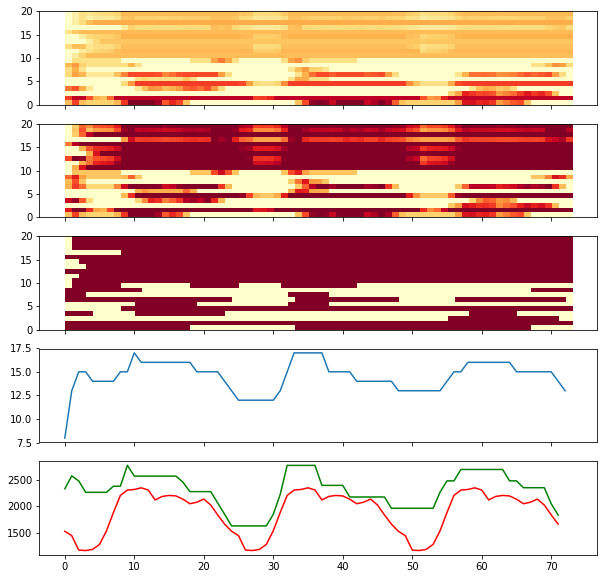

In [13]:
# Display some statistics
def displayProduction(ucp, pVal, uVal, pmax):
    N, T, p, u, v = ucp.N, ucp.T, ucp.p, ucp.u, ucp.v    
    f, axarr = plt.subplots(5, sharex=True, figsize=[10,10])
    # Production relative to global maximum
    axarr[0].imshow(pVal/max(pmax), extent=(0,T+1,0,N),
               interpolation='nearest', cmap=cm.YlOrRd,
               vmin=0, vmax=1, aspect='auto')
    # Production relative to maximum of each unit
    axarr[1].imshow(pVal/repeat(pmax, T+1), extent=(0,T+1,0,N),
               interpolation='nearest', cmap=cm.YlOrRd,
               vmin=0, vmax=1, aspect='auto')
    # On/off status
    axarr[2].imshow(uVal, extent=(0,T+1,0,N),
               interpolation='nearest', cmap=cm.YlOrRd,
               vmin=0, vmax=1, aspect='auto')    
    # Number of units in operation
    axarr[3].plot(np.sum(uVal, axis=0))
    # Demand coverage and spinning reserve
    axarr[4].plot(demand, 'r', np.sum(repeat(pmax,T)*uVal[:,1:], axis=0), 'g')

    plt.show()
    
displayProduction(ucp, pVal, uVal, pmax)

The horizontal axis is time. In the first three plots the history of each unit is represented by a single row. From top to bottom the five plots are:

1. Production level of each unit relative to the maximal possible production of any unit ($\frac{p_{i,t}}{\max_i(p^{\textrm{max}}_i)}$).
2. Production level of each unit relative to its own maximal possible production ($\frac{p_{i,t}}{p^{\textrm{max}}_i}$).
3. Which units are active/inactive ($u_{i,t}$).
4. The number of active units.
5. Red - the demand at time periods. Green - the maximal total power of all units active at any given period. The difference is the *spinning reserve* of the system.

## Reoptimization

We can easily add new constraints to an existing Fusion model. For example, we could generate a list of random failures by declaring certain $u_{i,t}$ to be $0$:

In [14]:
# Random switch-off of some generators
np.random.seed(0)
def consSOff(ucp, num):
    N, T, p, u, v = ucp.N, ucp.T, ucp.p, ucp.u, ucp.v   
    ucp.M.constraint(u.pick(list(np.random.randint(0,N,size=num)), list(np.random.randint(5,T,size=num))), 
        Domain.equalsTo(0.0))

We can now reoptimize the old model with the extra new constraints:

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 45196           
  Cones                  : 20              
  Scalar variables       : 5880            
  Matrix variables       : 0               
  Integer variables      : 2920            

Optimizer started.
Mixed integer optimizer started.
Threads used: 20
Presolve started.
Presolve terminated. Time = 1.05
Presolved problem: 4172 variables, 23792 constraints, 67807 non-zeros
Presolved problem: 18 general integer, 2692 binary, 1462 continuous
Clique table size: 680
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        0        0        NA                   1.0237076498e+07     NA          2.2   
0        1        0        0        1.0298496877e+07     1.0237076498e+07     0.60        4.3   
An optimal solution satisfying the relative gap t

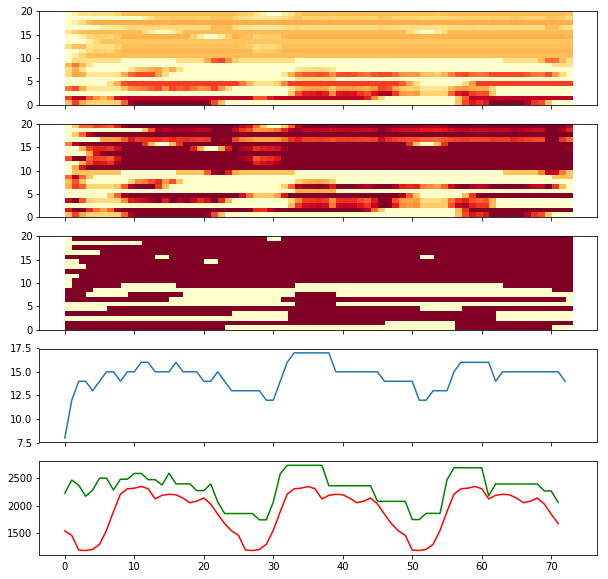

In [15]:
consSOff(ucp, 10)
ucp.M.setSolverParam("mioTolRelGap", 0.02) # 2%
ucp.M.solve()
pVal, uVal = results(ucp)
displayProduction(ucp, pVal, uVal, pmax)

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 